In [23]:
import sympy as sp
from lbmpy.stencils import LBStencil, Stencil
from lbmpy.moments import MOMENT_SYMBOLS, moment_matrix
import numpy as np
from sympy.plotting import plot

# Direct application of what I think is happening in gross 2010 paper

In [2]:
B = sp.symbols("beta")
rho0, rho, rho_v, rho_l = sp.symbols("rho_0 rho rho_v rho_l")
f0 = B*((rho - rho_v)**2)*((rho - rho_l)**2)
cs = sp.symbols("c_s")

mu0 = sp.Derivative(f0, rho).doit()
p0 = sp.simplify(rho*mu0 - f0)
p0

beta*(rho - rho_l)*(rho - rho_v)*(2*rho*(2*rho - rho_l - rho_v) - (rho - rho_l)*(rho - rho_v))

In [26]:
spinodal_line = sp.Derivative(f0, rho, 2).doit()
rhov_real = 0.1
rhol_real = 1.1
beta_real = 0.04
phase_line = sp.simplify(spinodal_line.subs({rho_v:rhov_real, rho_l:rhol_real, B:beta_real}))

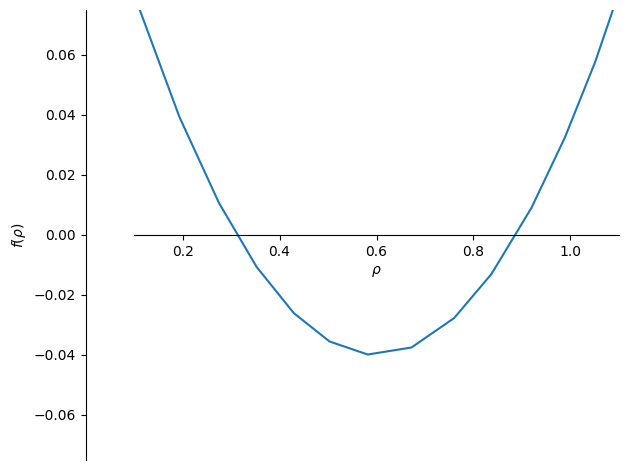

In [27]:
plot(phase_line, xlim = [rhov_real, rhol_real], ylim = [-0.075, 0.075])

## Moment matrix

In [3]:
d3q19 = LBStencil(Stencil.D3Q19)
D = len(d3q19[0])
Q = len(d3q19)
c = sp.Matrix(d3q19)

x, y, z = MOMENT_SYMBOLS
one = sp.core.sympify(1)
c2 = x**2+y**2+z**2
c4 = c2**2

moments = [ 
    one,
    x,
    y,
    z,
    c2-1,
    3*x**2-c2,
    y**2-z**2,
    x*y,
    y*z,
    z*x,
    (3*c2-5)*x,
    (3*c2-5)*y,
    (3*c2-5)*z,
    (y**2-z**2)*x,
    (z**2-x**2)*y,
    (x**2-y**2)*z,
    3*c4-6*c2+1,
    (2*c2-3)*(3*x**2-c2),
    (2*c2-3)*(y**2-z**2)
]

M = moment_matrix(moments, stencil=d3q19)

## Moment and equilibrium distribution calculation

In [7]:
kappa = sp.symbols('kappa')
pb = sp.symbols('p_b')
rho = sp.symbols('rho',cls=sp.Function)(x,y,z)
ux, uy, uz = sp.symbols('u_x, u_y, u_z')
cs = sp.sqrt(sp.Rational(1,3))
kx, ky, kz = sp.symbols('k_x, k_y, k_z')
ks = {x:kx,y:ky,z:kz}
u = sp.Matrix([ux,uy,uz])
Drho2 = sp.Matrix([ [ sp.Derivative(rho,a)*sp.Derivative(rho,b) for b in [x,y,z] ] for a in [x,y,z] ])
D2rho = sum([ sp.Derivative(rho,a,2) for a in [x,y,z] ])
G = kappa*Drho2

five36 = sp.Rational(5,36)
one9 = sp.Rational(1,9)
one12 = sp.Rational(1,12)
one36 = sp.Rational(1,36)
one72 = sp.Rational(1,72)

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

ww =  [ [[0]*3]*3 ] \
    + [ [ [ -one9, 0, 0], [0, five36, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [five36, 0, 0], [0,  -one9, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [ -one9, 0, 0], [0,  -one9, 0], [0, 0, five36] ] ]*2 \
    + [ [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ] ]

def f(i):
    f = w[i]/cs**2*pb \
        + w[i]/cs**2*rho*c[i,:].dot(u) \
        + w[i]/(2*cs**4)*rho*u.dot((c[i,:].T@c[i,:]-cs**2*sp.eye(D))@u) \
        - w[i]/cs**2*(kappa*rho*D2rho) \
        + sum([ ww[i][j][j]/cs**2*G[j,j] for j in range(D) ]) \
        + sum([ ww[i][j][(j+1)%D]/cs**2*G[j,(j+1)%D] for j in range(D) ])
    return f

feq = sp.Matrix([ f(i) for i in range(0,Q) ])
feq[0] = rho - sum(feq[1:])
feq.simplify()
mf = sp.simplify(M*feq)
mf

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                              rho(x, y, z)],
[                                                                                                                                                                                                                                                                                                                                                                          u_x*rho(x, y, z)],
[                                                                                                                                                                                                                                  

In [8]:
Drho2

Matrix([
[                         Derivative(rho(x, y, z), x)**2, Derivative(rho(x, y, z), x)*Derivative(rho(x, y, z), y), Derivative(rho(x, y, z), x)*Derivative(rho(x, y, z), z)],
[Derivative(rho(x, y, z), x)*Derivative(rho(x, y, z), y),                          Derivative(rho(x, y, z), y)**2, Derivative(rho(x, y, z), y)*Derivative(rho(x, y, z), z)],
[Derivative(rho(x, y, z), x)*Derivative(rho(x, y, z), z), Derivative(rho(x, y, z), y)*Derivative(rho(x, y, z), z),                          Derivative(rho(x, y, z), z)**2]])

In [9]:
D2rho

Derivative(rho(x, y, z), (x, 2)) + Derivative(rho(x, y, z), (y, 2)) + Derivative(rho(x, y, z), (z, 2))

## Calculation of noise covariance matrix

In [5]:
kappa = sp.symbols('kappa')
pb = sp.symbols('p_b')
rho = sp.symbols('rho',cls=sp.Function)(x,y,z)
ux, uy, uz = sp.symbols('u_x, u_y, u_z')
k, kx, ky, kz = sp.symbols('k, k_x, k_y, k_z')
# k = sp.symbols('k')
ks = {x:kx,y:ky,z:kz}
u = sp.Matrix([ux,uy,uz])
Drho2 = sp.Matrix([ [ 0 for b in [x,y,z] ] for a in [x,y,z] ])
D2rho = -k**2*rho
G = kappa*Drho2
cs = sp.sqrt(sp.Rational(1, 3))
five36 = sp.Rational(5,36)
one9 = sp.Rational(1,9)
one12 = sp.Rational(1,12)
one36 = sp.Rational(1,36)
one72 = sp.Rational(1,72)

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

ww =  [ [[0]*3]*3 ] \
    + [ [ [ -one9, 0, 0], [0, five36, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [five36, 0, 0], [0,  -one9, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [ -one9, 0, 0], [0,  -one9, 0], [0, 0, five36] ] ]*2 \
    + [ [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ] ]

def f(i):
    f = w[i]/cs**2*pb \
        + w[i]/cs**2*rho*c[i,:].dot(u) \
        + w[i]/(2*cs**4)*rho*u.dot((c[i,:].T@c[i,:]-cs**2*sp.eye(D))@u) \
        - w[i]/cs**2*(kappa*rho*D2rho) \
        + sum([ ww[i][j][j]/cs**2*G[j,j] for j in range(D) ]) \
        + sum([ ww[i][j][(j+1)%D]/cs**2*G[j,(j+1)%D] for j in range(D) ])
    return f

feq = sp.Matrix([ f(i) for i in range(0,Q) ])
feq[0] = rho - sum(feq[1:])
feq.simplify()
mf = sp.simplify(M*feq)
mf

Matrix([
[                                                                                                         rho(x, y, z)],
[                                                                                                     u_x*rho(x, y, z)],
[                                                                                                     u_y*rho(x, y, z)],
[                                                                                                     u_z*rho(x, y, z)],
[3*k**2*kappa*rho(x, y, z)**2 + 3*p_b + u_x**2*rho(x, y, z) + u_y**2*rho(x, y, z) + u_z**2*rho(x, y, z) - rho(x, y, z)],
[                                                                            (2*u_x**2 - u_y**2 - u_z**2)*rho(x, y, z)],
[                                                                                       (u_y**2 - u_z**2)*rho(x, y, z)],
[                                                                                                 u_x*u_y*rho(x, y, z)],
[                      

In [25]:
rho0 = sp.symbols("rho0")
k = sp.symbols('k')
cs = sp.symbols('c_s', real=True, cls=sp.Function)(k)

fbar = feq.subs({pb:rho*cs**2}).subs({rho:rho0,ux:0,uy:0,uz:0,kappa:0})
S = sp.symbols('S', cls=sp.Function)(k)/rho0*sp.diag(*fbar)
G = sp.simplify(M@S@M.T)
G

Matrix([
[                  S(k),              0,              0,              0, (3*c_s(k)**2 - 1)*S(k),                0,                  0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0, (1 - 3*c_s(k)**2)*S(k),                0,                  0],
[                     0, S(k)*c_s(k)**2,              0,              0,                      0,                0,                  0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0,                      0,                0,                  0],
[                     0,              0, S(k)*c_s(k)**2,              0,                      0,                0,                  0,                0,                0,                0,                0,                0,                0,                 

In [26]:
# lb,ls,lq,le = sp.symbols('lambda_b, lambda_s, lambda_q, lambda_e', real = True)
# lambdas = [0]*4 + [lb]*1 + [ls]*5 + [lq]*6 + [lb]*3
d = 3*(cs**2 - sp.Rational(1,3))
l = sp.symbols("lambda")
lambdas = [0]*4 + [l]*1 + [l]*5 + [l]*6 + [l]*3
Lambda = sp.diag(*lambdas)

Lambda[4,0] = -d*lambdas[4]
Lambda[16,0] = d*lambdas[16]

Lambda

Matrix([
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[lambda*(1 - 3*c_s(k)**2), 0, 0, 0, lambda,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0, lambda,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      

In [27]:
G

Matrix([
[                  S(k),              0,              0,              0, (3*c_s(k)**2 - 1)*S(k),                0,                  0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0, (1 - 3*c_s(k)**2)*S(k),                0,                  0],
[                     0, S(k)*c_s(k)**2,              0,              0,                      0,                0,                  0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0,                      0,                0,                  0],
[                     0,              0, S(k)*c_s(k)**2,              0,                      0,                0,                  0,                0,                0,                0,                0,                0,                0,                 

In [29]:
A = Lambda # Advection matrix A

Xi = sp.simplify(A@G + G@A.T)
# Xi = Xi/sp.Rational(1, 3)
Xi

Matrix([
[0, 0, 0, 0,                                         0,                       0,                         0,                         0,                         0,                         0,                       0,                       0,                       0,                         0,                         0,                         0,                                         0,                       0,                         0],
[0, 0, 0, 0,                                         0,                       0,                         0,                         0,                         0,                         0,                       0,                       0,                       0,                         0,                         0,                         0,                                         0,                       0,                         0],
[0, 0, 0, 0,                                         0,                       0,                         0,  

# Adding the pieces from the 2011 gross paper

## Moment matrix

In [8]:
d3q19 = LBStencil(Stencil.D3Q19)
Q = len(d3q19)
c = sp.Matrix(d3q19)
D = len(c)//Q
cs = sp.sqrt(sp.Rational(1,3))

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

x, y, z = MOMENT_SYMBOLS
one = sp.core.sympify(1)
c2 = x**2+y**2+z**2
c4 = c2**2

moments = [ 
    one,
    x,
    y,
    z,
    c2-1,
    x**2-y**2,
    c2-3*z**2,
    x*y,
    x*z,
    y*z,
    (3*c2-5)*x,
    (3*c2-5)*y,
    (3*c2-5)*z,
    (y**2-z**2)*x,
    (x**2-z**2)*y,
    (x**2-y**2)*z,
    3*c4-6*c2+1,
    (2*c2-3)*(x**2-y**2),
    (2*c2-3)*(c2-3*z**2)
]

M = moment_matrix(moments, stencil=d3q19)

N = [ sum([w[i]*M[a,i]**2 for i in range (Q)]) for a in range(Q) ]

## Momentum and equilibrium calculation

In [9]:
rho = sp.symbols('rho', cls=sp.Function, real=True)(x,y,z)
ux, uy, uz = sp.symbols('u_x, u_y, u_z', real=True)
pb = sp.symbols('p_b', real=True)
# mu = sp.symbols('mu_phi', real=True, cls=sp.Function)(rho)
kappa = sp.symbols('kappa', real=True)
Gamma = sp.symbols('Gamma_phi', real=True)
k = sp.symbols('k', real=True)
kB, T = sp.symbols('k_B T', real=True)
kT = sp.symbols('kT', real=True)

rho0 = sp.symbols('\\hat{\\rho}_0', real=True, constant=True)
drho = sp.symbols('\\delta\\hat{\\rho}', real=True)

In [10]:
u = sp.Matrix([ux,uy,uz])
D2rho = sum([ sp.Derivative(rho,a,2) for a in [x,y,z] ])
Drho2 = sp.Matrix([ [ sp.Derivative(rho,a)*sp.Derivative(rho,b) for b in [x,y,z] ] for a in [x,y,z] ])
G = kappa*Drho2

five36 = sp.Rational(5,36)
one9 = sp.Rational(1,9)
one12 = sp.Rational(1,12)
one36 = sp.Rational(1,36)
one72 = sp.Rational(1,72)

ww =  [ [[0]*3]*3 ] \
    + [ [ [ -one9, 0, 0], [0, five36, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [five36, 0, 0], [0,  -one9, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [ -one9, 0, 0], [0,  -one9, 0], [0, 0, five36] ] ]*2 \
    + [ [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ] ]

def f(i):
    f = w[i]/cs**2*pb \
        + w[i]/cs**2*rho*c[i,:].dot(u) \
        + w[i]/(2*cs**4)*rho*u.dot((c[i,:].T@c[i,:]-cs**2*sp.eye(D))@u) \
        - w[i]/cs**2*(kappa*rho*D2rho) \
        + sum([ ww[i][j][j]/cs**2*G[j,j] for j in range(D) ]) \
        + sum([ ww[i][j][(j+1)%D]/cs**2*G[j,(j+1)%D] for j in range(D) ])
    return f

feq = sp.Matrix([ f(i) for i in range(0,Q) ])
feq[0] = rho - sum(feq[1:])
mf = sp.simplify(M*feq)
mf

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                              rho(x, y, z)],
[                                                                                                                                                                                                                                                                                                                                                                          u_x*rho(x, y, z)],
[                                                                                                                                                                                                                                  

## Calculation of noise covarianc ematrix

In [11]:
cs = sp.symbols('c_s', cls=sp.Function, real=True)(k)

# advection operator
A = sp.diag(*[ sp.I*c[i,:]@sp.Matrix(sp.symbols('k_x, k_y, k_z', real=True)) for i in range(Q) ])
A = M@A@M.inv()

# # collision operator
lb,ls,lq,le = sp.symbols('lambda_b, lambda_s, lambda_q, lambda_epsilon')
cs = sp.symbols('c_s', cls=sp.Function, real=True)(k)
d = -6*(cs**2 - sp.Rational(1,3))

lambdas = [0]*4 + [lb]*3 + [ls]*3 + [lq]*6 + [lb] + 2*[lq]
Lambda = sp.diag(*lambdas)
Lambda[4,0] = -d/2*lb
Lambda[16,0] = d/2*lb
# Lambda[16,4] = -d/2*lb

# time evolution operator
L = A + Lambda

L

Matrix([
[                         0,     I*k_x,      I*k_y,      I*k_z,        0,        0,         0,        0,        0,        0,        0,        0,        0,         0,         0,        0,        0,          0,        0],
[                   I*k_x/3,         0,          0,          0,  I*k_x/3,  I*k_x/2,   I*k_x/6,    I*k_y,    I*k_z,        0,        0,        0,        0,         0,         0,        0,        0,          0,        0],
[                   I*k_y/3,         0,          0,          0,  I*k_y/3, -I*k_y/2,   I*k_y/6,    I*k_x,        0,    I*k_z,        0,        0,        0,         0,         0,        0,        0,          0,        0],
[                   I*k_z/3,         0,          0,          0,  I*k_z/3,        0,  -I*k_z/3,        0,    I*k_x,    I*k_y,        0,        0,        0,         0,         0,        0,        0,          0,        0],
[lambda_b*(3*c_s(k)**2 - 1), 2*I*k_x/3,  2*I*k_y/3,  2*I*k_z/3, lambda_b,        0,         0,        0,       

In [12]:
fbar = feq.subs({pb:rho0*cs**2,rho:rho0,ux:0,uy:0,uz:0})
G = sp.symbols('S', cls=sp.Function)(k)/rho0*sp.diag(*fbar)
G = sp.simplify(M@G@M.T)
G

Matrix([
[                                                              S(k),              0,              0,              0,  (6*\hat{\rho}_0*c_s(k)**2 - 2*\hat{\rho}_0)*S(k)/(2*\hat{\rho}_0),                  0,                0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0, (-6*\hat{\rho}_0*c_s(k)**2 + 2*\hat{\rho}_0)*S(k)/(2*\hat{\rho}_0),                  0,                0],
[                                                                 0, S(k)*c_s(k)**2,              0,              0,                                                                  0,                  0,                0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0,                                                                  0,                  0,               

In [13]:
Xi = sp.expand(L@G + G@L.adjoint())
# assert(Xi==Xi.T)
sp.simplify(Xi)

Matrix([
[                                0, 0, 0, 0,                                                                                                                 2*(3*c_s(k)**2 - 1)*S(k)*conjugate(lambda_b),                                                   0,                                                 0,                                                 0,                                                 0,                                                 0,                                                 0,                                                 0,                                                 0,                                                   0,                                                   0,                                                   0,                                                                                                                 2*(1 - 3*c_s(k)**2)*S(k)*conjugate(lambda_b),                                                   0,         